In [ ]:
import os
import sys
import gym
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/f1d7764b276cadb7365b1fdb6f6dd3fbd4e7bd8d/week08_pomdp/atari_util.py
    !wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/f1d7764b276cadb7365b1fdb6f6dd3fbd4e7bd8d/week08_pomdp/env_pool.py
    # Setup the attari driver for video games
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete
    # Install packages dependencies
    os.system(f"pip install gym[atari,accept-rom-license]=={gym.__version__}")
    
# If you are running on a server, launch xvfb to record game videos
# Please make sure you have xvfb installed
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

# Restart the Runtime
print("Restarting the Runtime...")
os.kill(os.getpid(), 9)

--2022-11-25 07:03:33--  https://raw.githubusercontent.com/yandexdataschool/Practical_RL/f1d7764b276cadb7365b1fdb6f6dd3fbd4e7bd8d/week08_pomdp/atari_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2229 (2.2K) [text/plain]
Saving to: ‘atari_util.py’

atari_util.py       100%[===================>]   2.18K  --.-KB/s    in 0s      

2022-11-25 07:03:34 (40.3 MB/s) - ‘atari_util.py’ saved [2229/2229]

--2022-11-25 07:03:34--  https://raw.githubusercontent.com/yandexdataschool/Practical_RL/f1d7764b276cadb7365b1fdb6f6dd3fbd4e7bd8d/week08_pomdp/env_pool.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133

**Note**: Please Restart The Kernel after Installing the dependencies.

In [ ]:
import os
import numpy as np
from IPython.core import display
import matplotlib.pyplot as plt

%matplotlib inline

### Kung-Fu, recurrent style

In this notebook we'll once again train RL agent for for Atari [KungFuMaster](https://gym.openai.com/envs/KungFuMaster-v0/), this time using recurrent neural networks.

![img](https://upload.wikimedia.org/wikipedia/en/6/66/Kung_fu_master_mame.png)

In [61]:
import time
import warnings
from IPython.display import clear_output
from collections import defaultdict
from typing import Text, List, Dict, Set, Union

import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from gym.wrappers import RecordVideo, RecordEpisodeStatistics

from atari_util import PreprocessAtari
warnings.filterwarnings("ignore", category=DeprecationWarning)

# We scale rewards to avoid exploding gradients during optimization. [ISSUE No.04 FACED ME]
reward_scale = 0.01

def make_env() -> gym.Env:
    env = gym.make("KungFuMasterDeterministic-v4")
    env = PreprocessAtari(env, height=42, width=42,
                          crop=lambda img: img[95:-50, 15:],
                          color=False, n_frames=1,
                          reward_scale=reward_scale)
    # Rendering frame per seconds
    env.metadata['render_fps'] = 30
    return env


env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (1, 42, 42)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


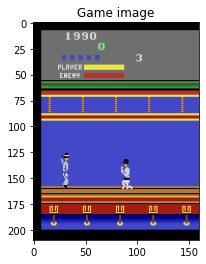

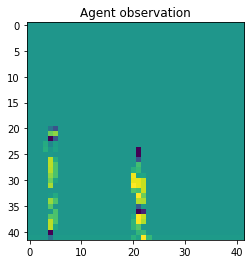

In [62]:
s = env.reset()

for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation')
plt.imshow(s.reshape([42, 42]))
plt.show()

### POMDP setting

The Atari game we're working with is actually a POMDP: your agent needs to know timing at which enemies spawn and move, but cannot do so unless it has some memory. 

Let's design another agent that has a recurrent neural net memory to solve this. Here's a sketch.

![img](https://github.com/yandexdataschool/Practical_RL/blob/master/week08_pomdp/img1.jpg?raw=1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
class SimpleRecurrentAgent(nn.Module):
    def __init__(self, obs_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        super(self.__class__, self).__init__()
        # NOTICE: Adding `Batch Normalization` to your network helps a lot in
        ## preventing gradient exploration and helps to have stable training
        ## and fast convergence

        # make sure to write down model.eval() while testing
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv1 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
        self.bn3 = nn.BatchNorm2d(32)
        self.flatten = Flatten()

        self.hid = nn.Linear(512, 128)
        self.rnn = nn.LSTMCell(128, 128)

        self.logits = nn.Linear(128, n_actions)
        self.state_value = nn.Linear(128, 1)

    def forward(self, prev_state, obs_t):
        """
        Takes agent's previous hidden state and a new observation,
        returns a new hidden state and whatever the agent needs to learn
        """

        # Apply the whole neural net for one step here.
        # See docs on self.rnn(...).
        # The recurrent cell should take the last feedforward dense layer as input.
        # <YOUR CODE>

        new_state = <YOUR CODE>
        logits =  <YOUR CODE>
        state_value =  <YOUR CODE>

        return new_state, (logits, state_value)

    def get_initial_state(self, batch_size):
        """Return a list of agent memory states at game start. Each state is a np array of shape [batch_size, ...]"""
        return torch.zeros((batch_size, 128)), torch.zeros((batch_size, 128))

    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        probs = F.softmax(logits, dim=-1)
        return torch.multinomial(probs, 1)[:, 0].data.numpy()

    def step(self, prev_state, obs_t):
        """ like forward, but obs_t is a numpy array """
        obs_t = torch.as_tensor(np.asarray(obs_t), dtype=torch.float32)
        (h, c), (l, s) = self.forward(prev_state, obs_t)
        return (h.detach(), c.detach()), (l.detach(), s.detach())

In [55]:
n_parallel_games = 5
gamma = 0.99

agent = SimpleRecurrentAgent(obs_shape, n_actions)

In [60]:
state = [env.reset()]
_, (logits, value) = agent.step(agent.get_initial_state(1), state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 tensor([[ 0.0456, -0.0310,  0.0063, -0.0446, -0.0242, -0.0712,  0.0619,  0.0142,
          0.0819, -0.0262,  0.0844,  0.0645,  0.0542, -0.0836]])
state values:
 tensor([0.0704])


### Let's play!


In [56]:
def evaluate(agent,
             env,
             video_dir: Union[Text, None]=None,
             n_games=1,
             record: Union[bool, Text]=False,
             debug: bool=False):
  
    """Plays an entire game start to end, returns session rewards."""
    # For Gym Debugging
    gym.logger.set_level(gym.logger.DEBUG) if debug else gym.logger.set_level(gym.logger.DISABLED)
    
    # For Recording
    if record:
      if record =="Statistic":
        env = RecordEpisodeStatistics(env)
      env = RecordVideo(env,
                        video_dir,
                        episode_trigger = lambda x: x % 2 == 0,
                        # video_length=60
                        )
    game_rewards = []
    agent.eval()
    for _ in range(n_games):
        # initial observation and memory
        observation = env.reset()
        prev_memories = agent.get_initial_state(1)

        total_reward = 0
        while True:
            new_memories, readouts = agent.step(prev_memories, observation[None, ...])
            action = agent.sample_actions(readouts)

            observation, reward, done, info = env.step(action[0])

            total_reward += reward
            prev_memories = new_memories
            if done:
                break

        game_rewards.append(total_reward / reward_scale)
    return game_rewards

In [58]:
rewards = evaluate(agent,
                   env,
                   video_dir='videos',
                   n_games=3,
                   record=True,
                   debug=True)

print(rewards)

INFO: Starting new video recorder writing to /content/videoss/rl-video-episode-0.mp4
DEBUG: Capturing video frame: path=/content/videoss/rl-video-episode-0.mp4
DEBUG: Starting ffmpeg with "ffmpeg -nostats -loglevel error -y -f rawvideo -s:v 160x210 -pix_fmt rgb24 -framerate 30 -i - -vf scale=trunc(iw/2)*2:trunc(ih/2)*2 -vcodec libx264 -pix_fmt yuv420p -r 30 /content/videoss/rl-video-episode-0.mp4"
DEBUG: Capturing video frame: path=/content/videoss/rl-video-episode-0.mp4
DEBUG: Capturing video frame: path=/content/videoss/rl-video-episode-0.mp4
DEBUG: Capturing video frame: path=/content/videoss/rl-video-episode-0.mp4
DEBUG: Capturing video frame: path=/content/videoss/rl-video-episode-0.mp4
DEBUG: Capturing video frame: path=/content/videoss/rl-video-episode-0.mp4
DEBUG: Capturing video frame: path=/content/videoss/rl-video-episode-0.mp4
DEBUG: Capturing video frame: path=/content/videoss/rl-video-episode-0.mp4
DEBUG: Capturing video frame: path=/content/videoss/rl-video-episode-0.mp4

[600.0, 300.0, 400.0]


In [59]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

print(video_path)
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

videoss/rl-video-episode-2.mp4


### Training on parallel games

We introduce a class called EnvPool - it's a tool that handles multiple environments for you. Here's how it works:
![img](https://github.com/yandexdataschool/Practical_RL/blob/master/week08_pomdp/img2.jpg?raw=1)

In [ ]:
from env_pool import EnvPool
pool = EnvPool(agent, make_env, n_parallel_games)

We gonna train our agent on a thing called __rollouts:__
![img](https://github.com/yandexdataschool/Practical_RL/blob/master/week08_pomdp/img3.jpg?raw=1)

A rollout is just a sequence of T observations, actions and rewards that agent took consequently.
* First __s0__ is not necessarily initial state for the environment
* Final state is not necessarily terminal
* We sample several parallel rollouts for efficiency

In [64]:
# for each of n_parallel_games, take 10 steps
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(25)

In [65]:
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ", rollout_obs.shape)

Actions shape: (5, 25)
Rewards shape: (5, 25)
Mask shape: (5, 25)
Observations shape:  (5, 25, 1, 42, 42)


# Actor-critic objective

Here we define a loss function that uses rollout above to train advantage actor-critic agent.


Our loss consists of three components:

* __The policy "loss"__
 $$ \hat J = {1 \over T} \cdot \sum_t { \log \pi(a_t | s_t) } \cdot A_{const}(s,a) $$
  * This function has no meaning in and of itself, but it was built such that
  * $ \nabla \hat J = {1 \over N} \cdot \sum_t { \nabla \log \pi(a_t | s_t) } \cdot A(s,a) \approx \nabla E_{s, a \sim \pi} R(s,a) $
  * Therefore if we __maximize__ J_hat with gradient descent we will maximize expected reward
  
  
* __The value "loss"__
  $$ L_{td} = {1 \over T} \cdot \sum_t { [r + \gamma \cdot V_{const}(s_{t+1}) - V(s_t)] ^ 2 }$$
  * Ye Olde TD_loss from q-learning and alike
  * If we minimize this loss, V(s) will converge to $V_\pi(s) = E_{a \sim \pi(a | s)} R(s,a) $


* __Entropy Regularizer__
  $$ H = - {1 \over T} \sum_t \sum_a {\pi(a|s_t) \cdot \log \pi (a|s_t)}$$
  * If we __maximize__ entropy we discourage agent from predicting zero probability to actions
  prematurely (a.k.a. exploration)

- **Policy Loss** 
<center>
<img src="https://www.informit.com/content/images/chap6_9780135172384/elementLinks/06eqa21_alt.jpg" width=500px/>
</center>
So we optimize a linear combination of $L_{td}$ $- \hat J$, $-H$

```

```

```

```

```

```


__One more thing:__ since we train on T-step rollouts, we can use N-step formula for advantage for free:
  * At the last step, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot V(s_{t+1}) - V(s) $
  * One step earlier, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot r(s_{t+1}, a_{t+1}) + \gamma ^ 2 \cdot V(s_{t+2}) - V(s) $
  * Et cetera, et cetera. This way agent starts training much faster since it's estimate of A(s,a) depends less on his (imperfect) value function and more on actual rewards. There's also a [nice generalization](https://arxiv.org/abs/1506.02438) of this.


__Note:__ it's also a good idea to scale rollout_len up to learn longer sequences. You may wish set it to >=20 or to start at 10 and then scale up as time passes.

In [66]:
def to_one_hot(y, n_dims=None):
    """ Take an integer tensor and convert it to 1-hot matrix. """
    y_tensor = y.to(dtype=torch.int64).contiguous().view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return y_one_hot

Build Reproducibility function

In [67]:
import random 
def set_seed(seed_value: int=42) -> None:
  os.environ['PYTHONHASHSEED'] = f"{seed_value}"
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)

  # If cuda
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [69]:
# adding lambda λ to make compromise between bias and variance.
lamda = 0.92 # best value according to (Schulman et al., 2018) if you are going to work with GAE
ENT_COEF = 0.01
GRADIENT_COEF = 0.5

In [70]:
opt = torch.optim.Adam(agent.parameters(), lr=1e-5)


def train_on_rollout(states, actions, rewards, is_not_done, prev_memory_states, gamma=0.99):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # shape: [batch_size, time, c, h, w]
    states = torch.tensor(np.asarray(states), dtype=torch.float32)
    actions = torch.tensor(np.array(actions), dtype=torch.int64)  # shape: [batch_size, time]
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32)  # shape: [batch_size, time]
    is_not_done = torch.tensor(np.array(is_not_done), dtype=torch.float32)  # shape: [batch_size, time]
    rollout_length = rewards.shape[1] - 1

    # predict logits, probas and log-probas using an agent.
    memory = [m.detach() for m in prev_memory_states]

    logits = []  # append logit sequence here
    state_values = []  # append state values here
    for t in range(rewards.shape[1]):
        obs_t = states[:, t]

        # use agent to comute logits_t and state values_t.
        # append them to logits and state_values array

        memory, (logits_t, values_t) = <YOUR CODE>

        logits.append(logits_t)
        state_values.append(values_t)

    logits = torch.stack(logits, dim=1)
    state_values = torch.stack(state_values, dim=1)
    probas = F.softmax(logits, dim=2)
    logprobas = F.log_softmax(logits, dim=2)

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    actions_one_hot = to_one_hot(actions, n_actions).view(
        actions.shape[0], actions.shape[1], n_actions)
    logprobas_for_actions = torch.sum(logprobas * actions_one_hot, dim=-1)

    # Now let's compute two loss components:
    # 1) Policy gradient objective.
    # Notes: Please don't forget to call .detach() on advantage term. Also please use mean, not sum.
    # it's okay to use loops if you want
    J_hat = 0  # policy objective as in the formula for J_hat

    # 2) Temporal difference MSE for state values
    # Notes: Please don't forget to call on V(s') term. Also please use mean, not sum.
    # it's okay to use loops if you want
    value_loss = 0

    cumulative_returns = state_values[:, -1].detach()

    for t in reversed(range(rollout_length)):
        r_t = rewards[:, t]                                # current rewards
        # current state values
        V_t = state_values[:, t]
        V_next = state_values[:, t + 1].detach()           # next state values
        # log-probability of a_t in s_t
        logpi_a_s_t = logprobas_for_actions[:, t]

        # update G_t = r_t + gamma * G_{t+1} as we did in week6 reinforce
        cumulative_returns = G_t = r_t + gamma * cumulative_returns

        # Compute temporal difference error (MSE for V(s))
        value_loss += <YOUR CODE>

        # compute advantage A(s_t, a_t) using cumulative returns and V(s_t) as baseline
        advantage = <YOUR CODE>
        advantage = advantage.detach()

        # compute policy pseudo-loss aka -J_hat.
        J_hat += <YOUR CODE>

    # regularize with entropy
    entropy_reg = <YOUR CODE: compute entropy regularizer>

    # add-up three loss components and average over time
    loss = -J_hat / rollout_length +\
        value_loss / rollout_length +\
           -ENT_COEF * entropy_reg

    # Gradient descent step
    <YOUR CODE>

    return (loss,
            value_loss / rollout_length,
            -J_hat / rollout_length,
            entropy_reg, # Indicates the Entropy not the Entropy Loss
            grad_norm)

In [ ]:
# let's test it
memory = list(pool.prev_memory_states)
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(25)

train_on_rollout(rollout_obs,
                 rollout_actions,
                 rollout_rewards,
                 rollout_mask,
                 memory)

(tensor(-0.0118, grad_fn=<AddBackward0>),
 tensor(3.9051e-05, grad_fn=<DivBackward0>),
 tensor(0.0145, grad_fn=<DivBackward0>),
 tensor(2.6377, grad_fn=<NegBackward0>),
 tensor(0.0037))

# Train 

just run train step and see if agent learns any better

In [ ]:
from IPython.display import clear_output
from tqdm import trange
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

set_seed()
rewards_history, grad_norm_history, entropy_history, entropy_loss_history, loss_history, Jhat, v_loss = [],[],[],[],[],[],[]
agent = SimpleRecurrentAgent(obs_shape, n_actions)
opt = torch.optim.Adam(agent.parameters(), lr=1e-5)


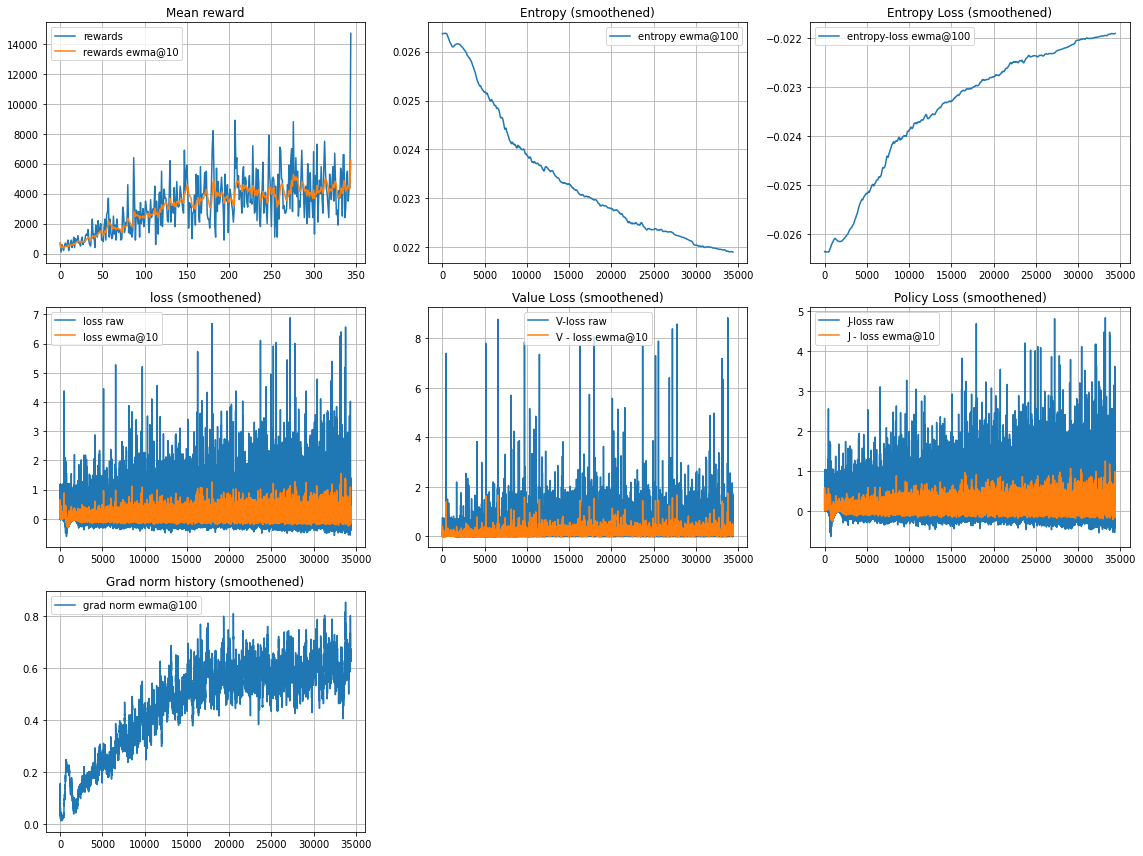

 69%|██████▉   | 34400/50000 [2:47:03<1:15:45,  3.43it/s]


Your agent has just beaten the homework record by:  14700.0


In [ ]:
rollout_len = 10
# Change to higher number of steps after you ensure you get progress
STEPS = int(5e+4) #int(15e+3)

agent.train()
for i in trange(STEPS):
  # We are going to start with 10 then scale it up!
  memory = list(pool.prev_memory_states)
  # Since gradient policy is considered on-policy, we have to increase the number
  ## of uitilized samples in the training phase since it can only utilize
  ## data generated from the current policy. (Lura, Kung, 2020. DRL Fudamentals)
  rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(rollout_len)
  loss, v, j, ent, grad  = train_on_rollout(rollout_obs, rollout_actions,
                              rollout_rewards, rollout_mask, memory)

  grad_norm_history.append(grad.data.numpy().item())
  entropy_history.append((ent * ENT_COEF).data.numpy().item())
  entropy_loss_history.append((ent * -ENT_COEF).data.numpy().item())
  loss_history.append(loss.data.numpy().item())
  Jhat.append(j.data.numpy().item())
  v_loss.append(v.data.numpy().item())

  if i % 100 == 0:
      clear_output(True)

      rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))

      plt.figure(figsize=[16, 12])
      plt.subplot(3, 3, 1)
      plt.title("Mean reward")
      plt.plot(rewards_history, label="rewards")
      plt.plot(
          moving_average(np.array(rewards_history), span=10), label="rewards ewma@10"
      )
      plt.grid()
      plt.legend()

      plt.subplot(3, 3, 2)
      plt.title("Entropy (smoothened)")
      plt.plot(
          moving_average(np.array(entropy_history), span=100),
          label="entropy ewma@100",
      )
      plt.grid()
      plt.legend()

      plt.subplot(3, 3, 3)
      plt.title("Entropy Loss (smoothened)")
      plt.plot(
          moving_average(np.array(entropy_loss_history), span=100),
          label="entropy-loss ewma@100",
      )
      plt.grid()
      plt.legend()

      plt.subplot(3, 3, 4)
      plt.title("loss (smoothened)")
      plt.plot(np.array(loss_history), label="loss raw")
      plt.plot(moving_average(np.array(loss_history), span=10), label="loss ewma@10")
      plt.grid()
      plt.legend()

      plt.subplot(3, 3, 5)
      plt.title("Value Loss (smoothened)")
      plt.plot(np.array(v_loss), label="V-loss raw")
      plt.plot(moving_average(np.array(v_loss), span=10), label="V - loss ewma@10")
      plt.grid()
      plt.legend()

      plt.subplot(3, 3, 6)
      plt.title("Policy Loss (smoothened)")
      plt.plot(np.array(Jhat), label="J-loss raw")
      plt.plot(moving_average(np.array(Jhat), span=10), label="J - loss ewma@10")
      plt.grid()
      plt.legend()

      plt.subplot(3, 3, 7)
      plt.title("Grad norm history (smoothened)")
      plt.plot(
          moving_average(np.array(grad_norm_history), span=100),
          label="grad norm ewma@100",
      )
      plt.grid()
      plt.legend()
      plt.tight_layout()
      plt.show()
      
      if rewards_history[-1] > 10000:
        print("\nYour agent has just beaten the homework record by: ", rewards_history[-1])
        break
      elif rewards_history[-1] >= 10000:
        print("\nYour agent has just passed the minimum homework threshold with score: ", rewards_history[-1])
        break
      elif 8000 <= rewards_history[-1] <= 8499:
        print("\nYour agent has just get 'Red' Belt with score: ", rewards_history[-1])
      elif 8500 <= rewards_history[-1] <= 9999:
        print("\nYour agent has just get 'Red-Black' Belt with score: ", rewards_history[-1])

      elif rewards_history[-1] >= 500:
        print("\nYour agent has earned the yellow belt: ", rewards_history[-1])
    
  if i % 500 == 0:
    rollout_len = min(40, rollout_len + 1)
    print(f"\nNumber of Interactions per steps: {rollout_len}")

Relax and grab some refreshments while your agent is locked in an infinite loop of violence and death.

__How to interpret plots:__

The session reward is the easy thing: it should in general go up over time, but it's okay if it fluctuates ~~like crazy~~. It's also OK if it reward doesn't increase substantially before some 10k initial steps. However, if reward reaches zero and doesn't seem to get up over 2-3 evaluations, there's something wrong happening.


Since we use a policy-based method, we also keep track of __policy entropy__ - the same one you used as a regularizer. The only important thing about it is that your entropy shouldn't drop too low (`< 0.1`) before your agent gets the yellow belt. Or at least it can drop there, but _it shouldn't stay there for long_.

If it does, the culprit is likely:
* Some bug in entropy computation. Remember that it is $ - \sum p(a_i) \cdot log p(a_i) $
* Your agent architecture converges too fast. Increase entropy coefficient in actor loss. 
* Gradient explosion - just [clip gradients](https://stackoverflow.com/a/56069467) and maybe use a smaller network
* Us. Or PyTorch developers. Or aliens. Or lizardfolk. Contact us on forums before it's too late!

If you're debugging, just run `logits, values = agent.step(batch_states)` and manually look into logits and values. This will reveal the problem 9 times out of 10: you'll likely see some NaNs or insanely large numbers or zeros. Try to catch the moment when this happens for the first time and investigate from there.

### "Final" evaluation

#### Save & Load the agent

In [ ]:
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(agent, "LOCATION TO SAVE YOUR AGENT")

In [ ]:
agent = torch.load("TEST LOADING: WRITE DOWN YOUR AGENT'S LOCATION ")

#### Evaluate

In [ ]:
rewards = evaluate(agent,
                   env,
                   video_dir='videos',
                   n_games=20,
                   record=True,
                   debug=False)

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

print(video_path)
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

videos/rl-video-episode-98.mp4
